In [1]:
%load_ext autoreload
%autoreload 2

from t_nachine.optimization import Analyzer
import pandas as pd
from tqdm import tqdm

/home/abdelelyds/Workspace/PythonProjects/just-trade-it/t_nachine/backtester/core/_plotting.py:43: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `core.set_bokeh_output(notebook=False)`.
  warnings.warn(


Loading BokehJS ...

In [2]:
path = "logs/bouncing_v1.csv"
df = pd.read_csv(path)

In [3]:
analyzer = Analyzer(df)

In [4]:
analyzer.win_rate

0.89

In [5]:
analyzer.best_trade, analyzer.worst_trade

(503.61, -1497.91)

In [6]:
analyzer.nb_trades

55384

In [7]:
analyzer.losing_streak_probability(n=2)

0.01

In [8]:
analyzer.winning_streak_probability(n=5)

0.56

In [9]:
analyzer.stats

Duration                                RiskToReward         \
                 mean  median   min      max     std         mean median   
WinningTrade                                                               
False         280.580 211.000 0.000 2490.000 267.691       -0.742 -1.000   
True          100.534  37.000 0.000 4464.000 182.394        0.179  0.154   

                                 
                min   max   std  
WinningTrade                     
False        -1.931 0.000 0.392  
True          0.000 4.581 0.105

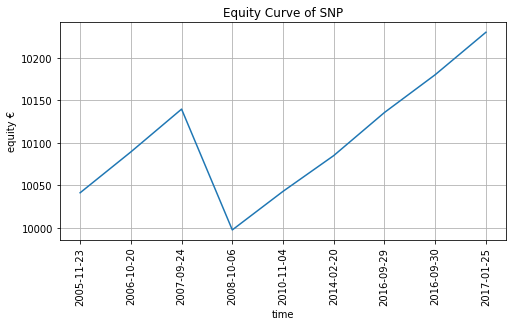

In [10]:
analyzer.plot_equity_curve(symbol='snp')

In [11]:
analyzer.plot_simulated_equity_curve(capital=1000, nb_trades=100, nb_simulations=100)

  7%|███                                        | 7/100 [00:04<00:58,  1.60it/s]


KeyboardInterrupt: 

In [10]:
analyzer.first_entry_time, analyzer.last_entry_time

('1964-05-18', '2017-11-10')

In [11]:
analyzer.pct_return

124.5

In [42]:
analyzer.backtest_results[['EntryTime', 'Symbol', 'RSI', 'RiskToReward']]

,EntryTime,Symbol,RSI,RiskToReward
0,2016-08-09,vno_l,0.653,-1.000
1,2016-06-29,vno_l,0.598,-1.000
2,2017-04-05,roam,0.570,0.239
3,2011-10-10,asur,0.530,1.027
4,2011-12-06,asur,0.668,0.977
...,...,...,...,...
56856,2013-09-10,rdi,0.619,0.491
56857,2014-09-17,rdi,0.593,1.039
56858,2015-11-27,rdi,0.430,-1.000
56859,2013-04-22,fdus,0.542,0.782


In [12]:
def compute_cohots(price: float) -> int:
    
    if price <= 5:
        return 1
    
    if price <= 10:
        return 2
    
    if price <= 50:
        return 3
    
    if price <= 100:
        return 4
    
    if price <= 500:
        return 5
    
    if price <= 1000:
        return 6

    return 7

In [13]:
results = analyzer.backtest_results.copy()

In [14]:
results['cohorts'] = results.EntryPrice.apply(compute_cohots)

In [15]:
results.groupby('cohorts').size()

cohorts
1     3377
2     7001
3    35746
4     6898
5     2175
6      122
7       65
dtype: int64

In [16]:
results.groupby('cohorts').WinningTrade.mean()

cohorts
1   0.905
2   0.902
3   0.886
4   0.872
5   0.848
6   0.787
7   0.769
Name: WinningTrade, dtype: float64

In [17]:
nb_trades_by_stocks = results.groupby('Symbol').size()
high_stocks = nb_trades_by_stocks[nb_trades_by_stocks > 20].index
results_high_stocks = results[results.Symbol.isin(high_stocks)]

In [18]:
win_rate_high_stocks = results_high_stocks.groupby('Symbol').WinningTrade.mean()

In [19]:
win_rate_high_stocks

Symbol
aa     0.909
aaba   0.917
aaon   0.840
aap    1.000
aapl   0.893
        ... 
xom    0.986
xray   1.000
xrx    0.812
yum    1.000
zion   0.955
Name: WinningTrade, Length: 646, dtype: float64

In [20]:
win_rate_high_stocks[win_rate_high_stocks > 0.96]

Symbol
aap    1.000
abg    0.962
abt    1.000
acgl   0.966
acn    1.000
        ... 
wy     1.000
xel    1.000
xom    0.986
xray   1.000
yum    1.000
Name: WinningTrade, Length: 231, dtype: float64

In [21]:
def process_max_pnl(pnl, winning):
    if winning:
        return None
    
    return pnl

def process_max_negative_pnl(negative_pnl, winning):
    if winning:
        return negative_pnl
    return None

In [22]:
results['MaxPnL'] = results.apply(lambda x: process_max_pnl(x.MaxPnL, x.WinningTrade), axis=1)

In [23]:
results['MaxNegativePnl'] = results.apply(lambda x: process_max_negative_pnl(x.MaxNegativePnl, x.WinningTrade), axis=1)

In [24]:
results['normMaxPnL'] = results['MaxPnL'] / results['OneR']

In [25]:
results['normMaxNegativePnL'] = results['MaxNegativePnl'] / results['OneR']

In [26]:
results

,Size,EntryBar,ExitBar,OneR,SlPrice,TpPrice,EntryPrice,ExitPrice,MaxPnL,MaxNegativePnl,...,ADX,WILLIAMS,Volume,Symbol,Duration,WinningTrade,RiskToReward,cohorts,normMaxPnL,normMaxNegativePnL
0,37.000,884.000,1202.000,13.485,12.935,27.520,26.420,25.156,0.044,NaN,...,0.176,-0.023,17286.000,vno_l,318.000,False,-0.094,3,0.003,NaN
1,36.000,856.000,1202.000,13.130,12.560,26.830,25.690,25.156,0.774,NaN,...,0.206,-0.061,86893.000,vno_l,346.000,False,-0.041,3,0.059,NaN
2,70.000,417.000,434.000,11.478,11.190,23.243,22.667,23.271,NaN,-0.437,...,0.146,-0.693,8036.000,roam,17.000,True,0.053,3,NaN,-0.038
3,94.000,1645.000,1664.000,1.225,1.012,2.663,2.237,2.663,NaN,-0.117,...,0.087,-0.396,5754.000,asur,19.000,True,0.348,1,NaN,-0.095
4,88.000,1681.000,1686.000,1.505,1.272,3.243,2.777,3.253,NaN,-0.190,...,0.351,-0.000,13649.000,asur,5.000,True,0.317,1,NaN,-0.126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55379,107.000,2048.000,2077.000,3.270,3.070,6.740,6.340,6.740,NaN,-0.260,...,0.110,-0.038,33554.000,rdi,29.000,True,0.122,2,NaN,-0.080
55380,26.000,2305.000,2343.000,4.840,3.980,10.540,8.820,10.540,NaN,-1.000,...,0.221,-0.103,22616.000,rdi,38.000,True,0.355,2,NaN,-0.207
55381,38.000,2607.000,2860.000,7.615,7.015,15.830,14.630,15.830,NaN,-4.920,...,0.242,-0.789,29500.000,rdi,253.000,True,0.158,3,NaN,-0.646
55382,29.000,458.000,565.000,6.245,5.535,13.199,11.779,13.199,NaN,-0.378,...,0.254,-0.159,122837.000,fdus,107.000,True,0.227,3,NaN,-0.061


## Losing Trades

In [35]:
losses = results[~results.WinningTrade]
losses['OneR'] = (losses.TpPrice - losses.EntryPrice) / 2
losses['MaxPnL/OneR'] = losses['MaxPnL'] / losses['OneR']

In [36]:
losses.MaxPnL.describe(percentiles=[0.75, 0.8, 0.9])

count   6342.000
mean       2.229
std        6.901
min        0.000
50%        0.933
75%        2.174
80%        2.615
90%        4.300
max      215.450
Name: MaxPnL, dtype: float64

In [37]:
losses['MaxPnL/OneR'].describe()

count   6342.000
mean       0.898
std        0.573
min        0.000
25%        0.394
50%        0.850
75%        1.379
max        3.474
Name: MaxPnL/OneR, dtype: float64

In [38]:
0.38 + 0.5 * (1 - 0.38)

0.69

In [32]:
losses.Duration.describe(percentiles=[0.1, 0.9])

count   6342.000
mean     280.580
std      267.691
min        0.000
10%       44.000
50%      211.000
90%      597.000
max     2490.000
Name: Duration, dtype: float64

In [115]:
## Less than 10 % of lossing reach at least 1.5R

## Winning Trades

In [33]:
wins = results[results.WinningTrade]
wins['absMaxNegativePnl'] = abs(wins.MaxNegativePnl)
wins['OneR'] = (wins.TpPrice - wins.EntryPrice) / 2
wins['absMaxNegativePnl/OneR'] = wins['absMaxNegativePnl'] / wins['OneR']

In [34]:
wins['absMaxNegativePnl/OneR'].describe(percentiles=[0.38, 0.40, 0.6, 0.75, 0.8, 0.9, 0.99])

count   49042.000
mean        2.288
std         2.781
min         0.000
38%         0.845
40%         0.906
50%         1.277
60%         1.782
75%         2.981
80%         3.587
90%         5.685
99%        13.123
max        39.351
Name: absMaxNegativePnl/OneR, dtype: float64

In [127]:
wins[['ATR', 'OneR', 'absMaxNegativePnl', 'absMaxNegativePnl/OneR']]

,ATR,OneR,absMaxNegativePnl,absMaxNegativePnl/OneR
2,0.133,0.288,0.437,1.517
3,0.129,0.213,0.117,0.547
4,0.152,0.233,0.190,0.814
5,0.138,0.413,0.277,0.669
6,0.494,0.639,0.970,1.517
...,...,...,...,...
55379,0.091,0.200,0.260,1.300
55380,0.224,0.860,1.000,1.163
55381,0.370,0.600,4.920,8.200
55382,0.510,0.710,0.378,0.532


In [117]:
abs(wins.MaxNegativePnl).describe(percentiles=[0.75, 0.8, 0.9, 0.99])

count   49042.000
mean        3.067
std         9.953
min         0.000
50%         1.137
75%         3.123
80%         3.959
90%         7.154
99%        26.190
max       834.780
Name: MaxNegativePnl, dtype: float64

In [119]:
((wins.TpPrice - wins.EntryPrice)/2).describe(percentiles=[0.75, 0.8, 0.99])

count   49042.000
mean        1.473
std         3.552
min         0.033
50%         0.900
75%         1.605
80%         1.845
99%         9.442
max       218.414
dtype: float64

In [33]:
wins.RiskToReward.describe()

count   49042.000
mean        0.179
std         0.105
min         0.000
25%         0.110
50%         0.154
75%         0.219
max         4.581
Name: RiskToReward, dtype: float64

In [34]:
wins.Duration.describe()

count   49042.000
mean      100.534
std       182.394
min         0.000
25%        15.000
50%        37.000
75%       103.000
max      4464.000
Name: Duration, dtype: float64

## Corrr

In [162]:
results[['OneR', 'ATR']].corr()

,OneR,ATR
OneR,1.000,0.111
ATR,0.111,1.000


In [163]:
results[['ATR', 'WinningTrade']].corr()

,ATR,WinningTrade
ATR,1.000,0.003
WinningTrade,0.003,1.000


In [164]:
results[['r1_distance', 'WinningTrade']].corr()

,r1_distance,WinningTrade
r1_distance,1.000,0.010
WinningTrade,0.010,1.000


In [165]:
results[['r2_distance', 'WinningTrade']].corr()

,r2_distance,WinningTrade
r2_distance,1.000,0.010
WinningTrade,0.010,1.000


In [166]:
results[['r3_distance', 'WinningTrade']].corr()

,r3_distance,WinningTrade
r3_distance,1.000,0.010
WinningTrade,0.010,1.000


In [167]:
results[['r4_distance', 'WinningTrade']].corr()

,r4_distance,WinningTrade
r4_distance,1.000,0.010
WinningTrade,0.010,1.000


In [168]:
from t_nachine.constants import TRADES_ATTRIBUTES
import seaborn as sns
import matplotlib.pyplot as plt

In [169]:
corr = results[TRADES_ATTRIBUTES + ['WinningTrade', 'Duration', 'oneR/ATR']].corr()

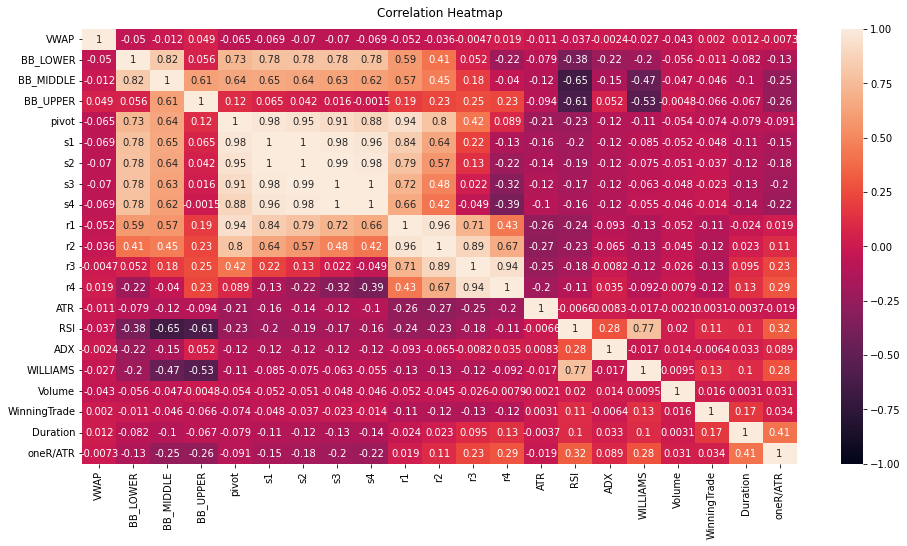

In [170]:
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [171]:
results['oneR/ATR'].describe()

count   58841.000
mean        1.804
std         0.600
min         0.000
25%         1.396
50%         1.707
75%         2.097
max         8.611
Name: oneR/ATR, dtype: float64

In [39]:
from t_nachine.backtester.core._plotting import plot
from t_nachine.backtester.core.backtest import Backtest
from t_nachine.strategies import Bouncing, Random
from finta import TA as ta

In [40]:
bt = Backtest(cash=2000)

In [41]:
symbol = results.Symbol.sample(1).values[0]

In [42]:
df = pd.read_csv(f'../archive/Stocks/{symbol}.us.txt')

In [43]:
ta.MACD(df)

,MACD,SIGNAL
0,0.000,0.000
1,0.003,0.002
2,0.005,0.003
3,0.006,0.004
4,0.009,0.006
...,...,...
3196,-0.836,-0.056
3197,-1.045,-0.254
3198,-1.197,-0.443
3199,-1.401,-0.634


In [44]:
res = bt.run(strategy=Bouncing, data=df)

In [48]:
t =res._trades

In [49]:
t

,Size,EntryBar,ExitBar,OneR,SlPrice,TpPrice,EntryPrice,ExitPrice,MaxPnL,MaxNegativePnl,...,s4,r1,r2,r3,r4,ATR,RSI,ADX,WILLIAMS,Volume
0,24,90,246,8.236,7.401,17.545,15.637,17.545,1.767,-1.010,...,0.919,0.975,0.983,0.995,1.007,0.318,0.651,0.375,-0.432,168345
1,21,186,276,8.609,7.632,18.473,16.241,18.473,2.061,-1.614,...,0.938,0.998,1.006,1.019,1.031,0.314,0.509,0.112,-0.350,139304
2,32,460,491,10.222,9.555,21.295,19.777,21.295,1.290,-1.677,...,0.973,0.992,0.995,0.999,1.003,0.384,0.577,0.328,-0.291,351648
3,24,473,496,10.200,9.330,21.519,19.530,21.519,1.777,-1.430,...,0.957,0.998,1.003,1.012,1.021,0.448,0.524,0.222,-0.437,89634
4,34,513,525,10.444,9.783,21.730,20.227,22.853,1.098,-0.791,...,0.964,0.989,0.993,0.998,1.004,0.683,0.436,0.243,-0.632,446192
5,32,545,549,11.245,10.529,23.406,21.774,23.406,1.043,-0.239,...,0.941,0.977,0.982,0.990,0.998,0.396,0.707,0.187,-0.031,458640
6,22,536,550,11.310,10.246,23.989,21.556,23.989,2.094,-0.627,...,0.956,0.997,1.003,1.012,1.021,0.544,0.608,0.218,-0.592,444394
7,26,1503,1551,10.023,9.077,21.260,19.100,21.260,1.719,-0.744,...,0.925,0.955,0.959,0.965,0.972,0.503,0.669,0.175,-0.117,754096
8,25,1585,1598,10.910,9.901,23.118,20.811,23.118,2.087,-0.314,...,0.937,0.975,0.980,0.989,0.997,0.554,0.504,0.208,-0.498,428089
9,22,1715,1746,11.434,10.288,24.347,21.722,24.347,2.436,-0.214,...,0.925,0.970,0.976,0.985,0.995,0.774,0.519,0.122,-0.501,628520


In [45]:
plot(df=df, results=res, indicators=res._strategy._indicators)

Row(id='1319', ...)

In [46]:
res

Start                                  0.000
End                                 3200.000
Duration                            3200.000
Exposure Time [%]                     41.799
Equity Final [$]                    3558.806
Equity Peak [$]                     3558.806
Return [%]                             0.000
Buy & Hold Return [%]                417.547
Return (Ann.) [%]                        NaN
Volatility (Ann.) [%]                    NaN
Sharpe Ratio                             NaN
Sortino Ratio                            NaN
# Trades                              24.000
Win Rate [%]                          95.833
Best Trade [%]                        19.569
Worst Trade [%]                       -4.986
Profit Factor                         52.819
Expectancy [%]                        10.765
SQN                                    9.800
_strategy                           Bouncing
_equity_curve                   Equity
0 ...
_trades                      Size  EntryB...
dtype: obj

In [47]:
66.67 * 0.949 - (100 - 66.67) * 1

29.93983